# Wind Capture Price Analysis

<br>

### Imports

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

<br>

### Helper Functions

In [2]:
def hide_spines(ax, positions=['top', 'right']):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), 'Position must be passed as a list'
    
    for position in positions:
        ax.spines[position].set_visible(False)
        
def try_accept(exception, default=None):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            try:
                return func(*args, **kwargs)
            except:
                return exception
        return wrapper
    return decorator

def rgb_2_plt_tuple(rgb_tuple):
    plt_tuple = tuple([x/255 for x in rgb_tuple])
    return plt_tuple

<br>

### Reading in Data

In [3]:
df = pd.read_csv('data/EI.csv')

df.index = pd.to_datetime(df['local_datetime'], utc=True)
df.index.name = 'local_datetime'
df = df.drop(columns=['local_datetime'])

df.head()

,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,windOnshore,windOffshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


<br>

### Determining the Wind Capture Price

Here we weight the day ahead market price for each year by the wind generation seen for a given settlement period

In [4]:
years = df.index.year.unique()
s_wind_cp = pd.Series(index=years)

for year in years:
    df_yr = (df
             .loc[df.index.year==year]
             [['day_ahead_price', 'wind']]
             .dropna()
            )
    
    s_wind_cp.loc[year] = np.average(df_yr['day_ahead_price'], weights=df_yr['wind'])

s_wind_cp

local_datetime
2009    36.144464
2010    41.632910
2011    46.676091
2012    44.259317
2013    49.151434
2014    41.880771
2015    38.265023
2016    37.495329
2017    44.289960
2018    56.710341
2019    41.673324
dtype: float64

<br>

The issue with looking at just nominal values is that it doesn't take into account inflation.

The CfD auction prices are given in £2012 so we'll convert the capture prices into 2012 values as well

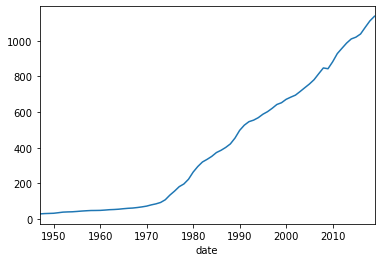

In [5]:
df_inflation = pd.read_csv('data/inflation.csv', skiprows=6, names=['date', 'CPI'])

df_inflation['date'] = pd.to_datetime(df_inflation['date'], format='%Y %b')
df_inflation = df_inflation.set_index('date')['CPI']
df_inflation = df_inflation.resample('YS').mean()
df_inflation.index = df_inflation.index.year

df_inflation.plot()

<br>

We now need to create a new index which is relative to £2012 which is what the CfDs are provided in 

In [6]:
s_inflation_2012 = df_inflation.loc[s_wind_cp.index]/df_inflation.loc[2012]
s_inflation_2012

local_datetime
2009    0.880355
2010    0.921023
2011    0.968923
2012    1.000000
2013    1.030416
2014    1.054810
2015    1.065166
2016    1.083720
2017    1.122560
2018    1.160086
2019    1.187625
Name: CPI, dtype: float64

<br>

We can now plot the relationship again using the 2012 adjusted prices

Text(0, 0.5, 'Weighted Wind Capture Price\n(DAM £2012/MWh)')

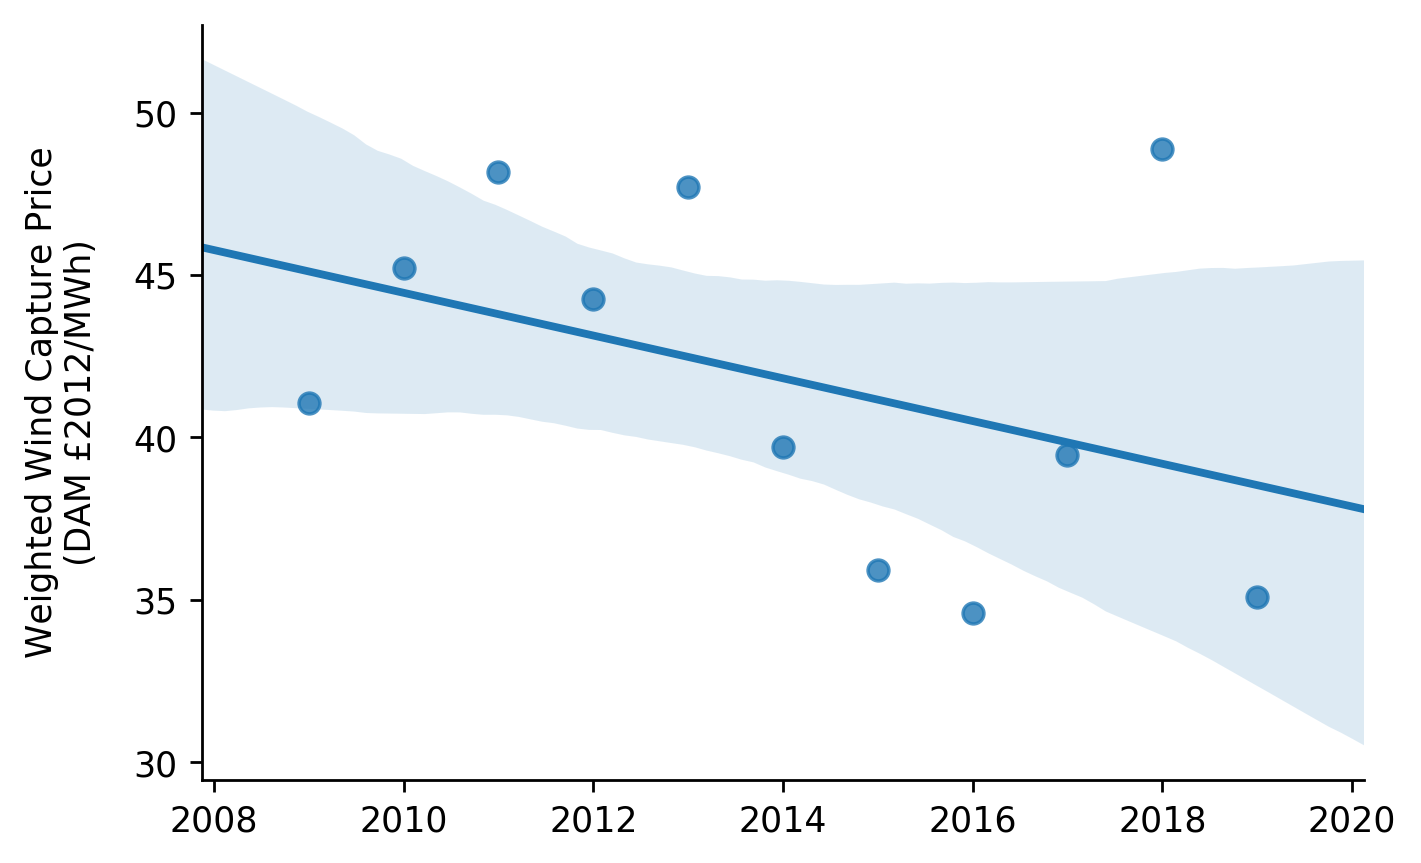

In [7]:
s_wind_cp_2012 = s_wind_cp/s_inflation_2012

## Plotting
fig, ax = plt.subplots(dpi=250)

sns.regplot(s_wind_cp_2012.index.values, s_wind_cp_2012.values)

hide_spines(ax)
ax.set_ylabel('Weighted Wind Capture Price\n(DAM £2012/MWh)', labelpad=10)

<br>

### Determining the Market Average & Wind Average Delta

Text(0, 0.5, 'Day-Ahead Price\n(£2012/MWh)')

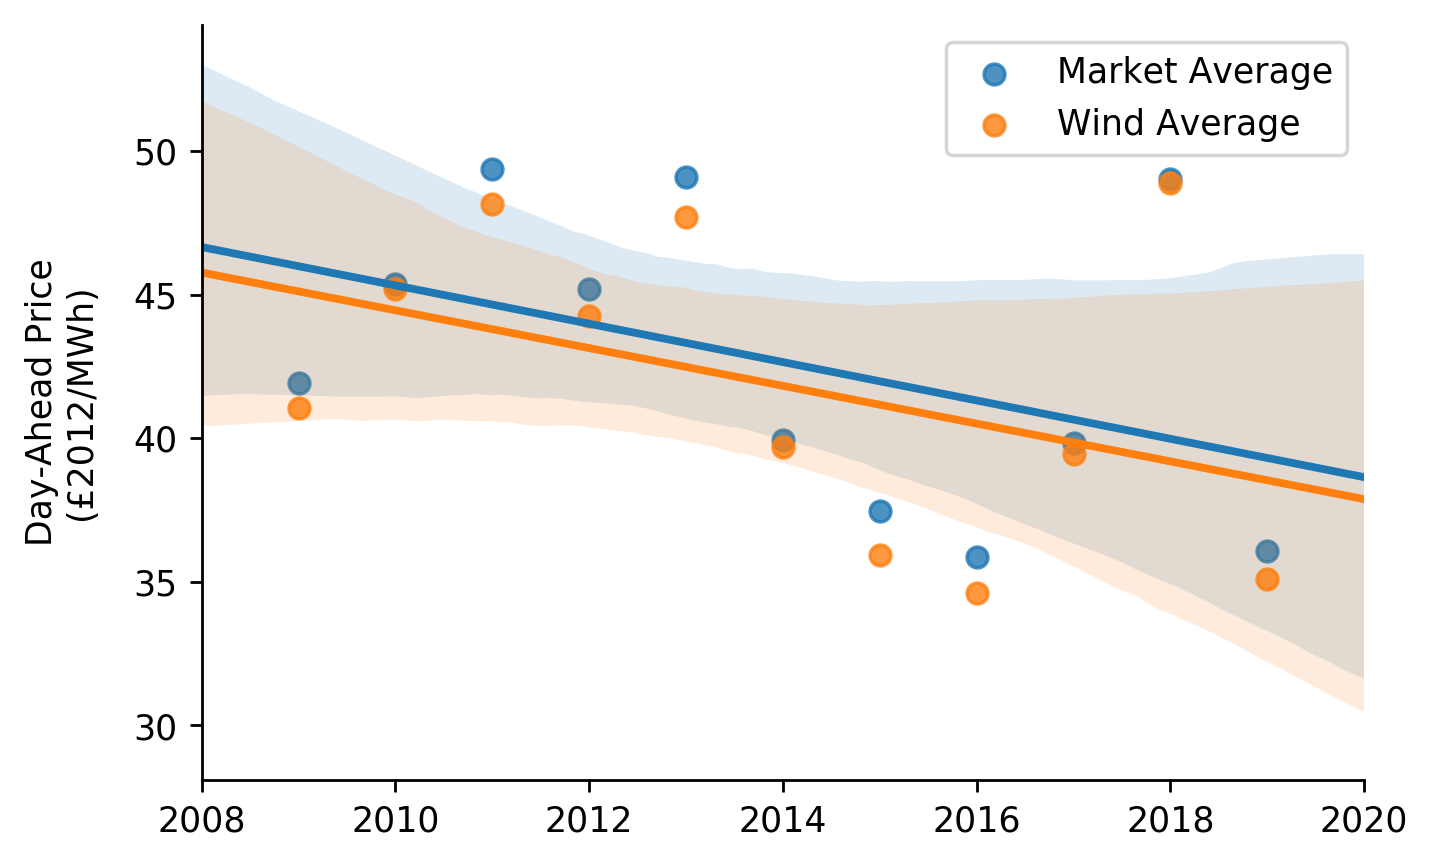

In [8]:
s_DAM = df['day_ahead_price'].resample('YS').mean()
s_DAM.index = s_DAM.index.year
s_DAM_2012 = s_DAM/s_inflation_2012

## Plotting
fig, ax = plt.subplots(dpi=250)

sns.regplot(s_DAM_2012.index.values, s_DAM_2012.values, label='Market Average')
sns.regplot(s_wind_cp_2012.index.values, s_wind_cp_2012.values, label='Wind Average')

hide_spines(ax)
ax.legend(frameon=True)
ax.set_xlim(2008, 2020)
ax.set_ylabel('Day-Ahead Price\n(£2012/MWh)', labelpad=10)

<br>

In [9]:
s_wind_cp_delta_2012 = (s_wind_cp_2012 - s_DAM_2012)
mean_delta = s_wind_cp_delta_2012.mean()

print(f'There was an average difference of {round(mean_delta, 2)} (£/MWh) between average annual day-ahead prices and day-ahead prices weighted for wind')

There was an average difference of -0.83 (£/MWh) between average annual day-ahead prices and day-ahead prices weighted for wind


<br>

### Regressing the Wind Capture Price

We'll use 'statsmodels' to carry out a regression and approximate the long term trend for wind capture prices. 

With so few points and a relatively volatile market this is very much a crude approximation, but it is an improvement on simply taking an average.

Additionaly, extrapolating 20 years ahead based on only 10 years of data is bad practice. Once again the reasons for taking this approach are that we do know that price cannibilisation is increasing and will continue to get worse as more wind capacity comes online.

In [13]:
X = s_wind_cp_2012.index.values
y = s_wind_cp_2012.values

X = sm.add_constant(X, prepend=False)
LR_model = sm.OLS(y, X)

results = LR_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1.804
Date:                Wed, 04 Dec 2019   Prob (F-statistic):              0.212
Time:                        20:25:36   Log-Likelihood:                -32.506
No. Observations:                  11   AIC:                             69.01
Df Residuals:                       9   BIC:                             69.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6578      0.490     -1.343      0.2

C:\Users\ABour\Anaconda3\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<br>

Finally we make our predictions and save the results

In [19]:
years_range = np.linspace(2010, 2040, 31).astype(int)
pred_wind_cp = results.predict(sm.add_constant(years_range, prepend=False))

s_pred = pd.Series(pred_wind_cp, index=years_range)
s_pred.head()

2010    44.453961
2011    43.796122
2012    43.138282
2013    42.480442
2014    41.822603
dtype: float64

In [24]:
s_pred.index.name = 'year'
s_pred.to_csv('data/wind_capture_price_pred.csv', header=['price'])